In [1]:
import numpy as np
import glob
import os
import sys
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import cv2
import imutils
import pandas as pd
import re
import datetime


from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split#import spams

from skimage.util import pad
import skimage

import sys

import time
import math
import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing import image
import keras.backend as K
import random
from sklearn.metrics import f1_score
from skimage.transform import resize
from skimage.filters import threshold_otsu
from tqdm import tqdm_notebook as tqdm 
#from tensorflow.keras.callbacks import TensorBoard

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction=0.2
config.gpu_options.allow_growth=True ##to use gpu as needed
config.log_device_placement = True  
sess = tf.Session(config=config)
set_session(sess)
K.tensorflow_backend._get_available_gpus()





Using TensorFlow backend.
W1004 16:00:02.708280 140309252515648 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1004 16:00:02.710374 140309252515648 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
!nvidia-smi

Fri Oct  4 16:00:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B1:00.0 Off |                    0 |
| N/A   34C    P0    53W / 300W |    318MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
print("Keras : {}".format(keras.__version__))
print("tensorflow : {}".format(tf.__version__))


Keras : 2.2.4
tensorflow : 1.14.0


In [4]:
def create_data():
    
    def rot_image(img):
        test=img.copy()
        rot=imutils.rotate(test,270)
        rot=cv2.flip(rot,1)
        return rot

    def poly2boundry(x,y,img_array):
        if len(x)==2 and len(y)==2:
            rr,cc=draw.line(x[0],y[0],x[1],y[1])
        else:
            rr, cc = draw.polygon_perimeter(x, y)
        img_array[rr,cc]=[255]
        return img_array

    def check_in_bounds(x,y,bound):

        if x>=bound:
            x=bound-1
        if y>=bound:
            y=bound-1
        if x<0:
            x=0
        if y<0:
            y=0
        return x,y

    
    
    bi_1_path="/datalab/nuclei_seg/binary_images_1"
    if not os.path.exists(bi_1_path):
        os.mkdir(bi_1_path)
        
    bi_2_path="/datalab/nuclei_seg/binary_images_2"
    if not os.path.exists(bi_2_path):
        os.mkdir(bi_2_path)
    png_name=glob.glob('/datalab/nuclei_seg/png_images/*.PNG')
    for count,name in enumerate(png_name):
        print("File {} is {}".format(count,name))
        new_name=name.replace('png_images','binary_images_1')
        new_name_2=name.replace('png_images','binary_images_2')
        xml_name=name.replace('/datalab/nuclei_seg/png_images/','/datalab/nuclei_seg/Annotations/')
        xml_name=xml_name.replace('.PNG','.xml')
        tree=ET.parse(xml_name)
        root=tree.getroot()
        img_test=np.zeros(shape=(1000,1000),dtype=np.uint8)
        img_test_2=np.zeros(shape=(1000,1000),dtype=np.uint8)

        print("The number of regions :{}".format(len([v.tag for v in root.iter('Vertices')])))
        for v in root.iter('Vertices'):
            X=[]
            Y=[]

            for child in v:
                x=int(eval(child.attrib['X']))
                y=int(eval(child.attrib['Y']))
                x,y=check_in_bounds(x,y,1000)



                X.append(x)
                Y.append(y)


            r_nucleus,c_nucleus=draw.polygon(X,Y)
            img_test[r_nucleus,c_nucleus]=255
            img_test_2=poly2boundry(X,Y,img_test_2)


        #img_test.dtype=np.uint8
        x,y=np.where(img_test_2==255)
        for i,a in enumerate(x):
            img_test_2[a-1:a+2,y[i]-1:y[i]+2]=255
            #img_test[a-1:a+2,y[i]-1:y[i]+2]=0
            img_test_2.dtype='uint8'
        
        img_test=rot_image(img_test)
        img_test_2=rot_image(img_test_2)
        cv2.imwrite(new_name,img_test)
        cv2.imwrite(new_name_2,img_test_2)

    print("DONE")
    
#create_data()

In [5]:

def check_list():

    img_path='/datalab/nuclei_seg/norm_ideal'
    mask_1_path='/datalab/nuclei_seg/binary_images_1'
    mask_2_path='/datalab/nuclei_seg/binary_images_2'

    img_list=glob.glob('{}/*.PNG'.format(img_path))
    b1_list=[x.replace('norm_ideal','binary_images_1') for x in img_list]
    b2_list=[x.replace('norm_ideal','binary_images_2') for x in img_list]

    for x,y,z in zip(img_list,b1_list,b2_list):

        if x.strip('/')[-1]!=y.strip('/')[-1] or x.strip('/')[-1]!=z.strip('/')[-1] or y.strip('/')[-1]!=z.strip('/')[-1]:
            print("ERROR")

    print("NO ERROR")

    

check_list()

NO ERROR


In [ ]:
def create_patches(img_path,mask_1_path,mask_2_path,patch_size=128):
    bi_1_patches="/datalab/nuclei_seg/b1_pat"
    bi_2_patches="/datalab/nuclei_seg/b2_pat"
    img_patches="/datalab/nuclei_seg/img_pat"
    if not os.path.exists(bi_1_patches):
        os.mkdir(bi_1_patches)
        print("Made {} dir".format(bi_1_patches))
    if not os.path.exists(bi_2_patches):
        os.mkdir(bi_2_patches)
        print("Made {} dir".format(bi_2_patches))
    if not os.path.exists(img_patches):
        os.mkdir(img_patches)
        print("Made {} dir".format(img_patches))
    img_list=glob.glob('{}/*.PNG'.format(img_path))
    b1_list=glob.glob('{}/*.PNG'.format(mask_1_path))
    b2_list=glob.glob('{}/*.PNG'.format(mask_2_path))
    for count,img_path in (enumerate(img_list)):
        img=imread(img_path)
        b1=imread(b1_list[count])
        b2=imread(b1_list[count])
        r,c,_=img.shape#1000,1000
        
        new_r_count=(math.ceil((r-patch_size)/patch_size)+1)#8
        new_c_count=(math.ceil((c-patch_size)/patch_size)+1)#8


        pad_r1=((new_r_count-1)*patch_size-r+patch_size)//2 #12
        pad_r2=((new_r_count-1)*patch_size-r+patch_size)-pad_r1 #12
        pad_c1=((new_c_count-1)*patch_size-c+patch_size)//2 #12
        pad_c2=((new_c_count-1)*patch_size-c+patch_size)-pad_c1#12



        arr_img=np.pad(img, [(pad_r1,pad_r2),(pad_c1,pad_c2),(0,0)], 'constant', constant_values=0)#1024 1024 3
        arr_b1=np.pad(b1, [(pad_r1,pad_r2),(pad_c1,pad_c2)], 'constant', constant_values=0)
        arr_b2=np.pad(b2, [(pad_r1,pad_r2),(pad_c1,pad_c2)], 'constant', constant_values=0)

        
        window_shape=(patch_size,patch_size,3)
        window_shape_binary=(patch_size,patch_size)
        arr_out=skimage.util.view_as_windows(arr_img, window_shape, step=patch_size)
        arr_out_binary1=skimage.util.view_as_windows(arr_b1, window_shape_binary, step=patch_size)
        arr_out_binary2=skimage.util.view_as_windows(arr_b2, window_shape_binary, step=patch_size)
        
        x,y=arr_out.shape[:2]
        ar2=arr_out.reshape((-1,patch_size,patch_size,3))
        ar2_b1=arr_out_binary1.reshape((-1,patch_size,patch_size))
        ar2_b2=arr_out_binary2.reshape((-1,patch_size,patch_size))
        for i in range(ar2.shape[0]):
            
            sub_img=ar2[i]
            b1_sub_img=ar2_b1[i]
            b2_sub_img=ar2_b2[i]
            sub_image_path=os.path.join(img_patches,img_path.split('/')[-1].split('.')[0]+"_{}.png".format(i))
            sub_image_path_b1=os.path.join(bi_1_patches,img_path.split('/')[-1].split('.')[0]+"_{}.png".format(i))
            sub_image_path_b2=os.path.join(bi_2_patches,img_path.split('/')[-1].split('.')[0]+"_{}.png".format(i))
            skimage.io.imsave(sub_image_path,sub_img)
            skimage.io.imsave(sub_image_path_b1,b1_sub_img)
            skimage.io.imsave(sub_image_path_b2,b2_sub_img)
            
            
img_path='/datalab/nuclei_seg/norm_ideal'
mask_1_path='/datalab/nuclei_seg/binary_images_1'
mask_2_path='/datalab/nuclei_seg/binary_images_2'
#create_patches(img_path,mask_1_path,mask_2_path) 

In [6]:
class UnetDataGenerator(keras.utils.Sequence):

    def __init__(self,image_IDs,IMAGE_PATH,MASK_PATH,batch_size=256,sample_wise=False,feature_wise=False,scale=1,\
                 shuffle=True):
        print("Number of sample : {}".format(len(image_IDs)))

        self.image_IDs = image_IDs
        self.IMAGE_PATH=IMAGE_PATH
        self.MASK_PATH=MASK_PATH
        self.batch_size=batch_size
        self.sample_wise=sample_wise
        self.feature_wise=feature_wise
        self.scale=scale
        self.shuffle = shuffle
        if self.feature_wise==True:
            self.mean_value=np.zeros(3)#np.array([154.55561068,100.37918644,167.97885898])
            self.std_value=np.ones(3)#np.array([50.64775462,55.05548022,36.14331006])
        self.on_epoch_end()
        

    def __len__(self):
        return int(np.ceil(len(self.image_IDs) / self.batch_size))
    

    def __getitem__(self, index):
    
        image_ID_temp= self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X=[]
        Y=[]
        for ID in image_ID_temp:
            x, y = self.__data_generation(ID)
            X.append(x)
            Y.append(y)
            
        X=np.array(X)
        Y=np.array(Y)

        return X, Y

    def on_epoch_end(self):
        
        self.indices = np.arange(len(self.image_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            

    def __data_generation(self, image_ID_temp):
        
        img_path=os.path.join(self.IMAGE_PATH,self.image_IDs[image_ID_temp])
        
        mask_name=self.image_IDs[image_ID_temp]#.split('.')[0]+'_mask.jpg'
        mask_path_1=os.path.join(self.MASK_PATH[0],mask_name)
        mask_path_2=os.path.join(self.MASK_PATH[1],mask_name)
        
        X = imread(img_path)
        #X=resize(X,(1024,1024,3))
        
        if self.scale!=1 and self.sample_wise==True:
            sys.exit("Scale and sample_wise, both cannot be implemneted")
        
        X=X*self.scale
        
        if self.sample_wise==True:
            X=np.array(X,np.float64)
            X[:,:,0]=(X[:,:,0]-np.mean(X[:,:,0]))/np.std(X[:,:,0])
            X[:,:,1]=(X[:,:,1]-np.mean(X[:,:,1]))/np.std(X[:,:,1])
            X[:,:,2]=(X[:,:,2]-np.mean(X[:,:,2]))/np.std(X[:,:,2])
            
        if self.feature_wise==True:
            X=np.array(X,np.float64)
            X=(X-self.mean_value)/self.std_value
        #X=np.expand_dims(X,axis=0)
        y1=imread(mask_path_1,as_gray=True)
        y2=imread(mask_path_2,as_gray=True)
        y=np.expand_dims(y1,axis=2)#np.array([y1])#,y2])
        y=np.stack([y1,y2],axis=2)
        y=y/255
        
        return X,y

In [7]:
INPUT_IMAGE_PATH='/datalab/nuclei_seg/img_pat'
MASK_1_PATH='/datalab/nuclei_seg/b1_pat'
MASK_2_PATH='/datalab/nuclei_seg/b2_pat'
MASK_PATH=[MASK_1_PATH,MASK_2_PATH]

img_list=os.listdir(INPUT_IMAGE_PATH)
img_list=[name for name in img_list if '.png' in name ]
train_list=img_list[:int(0.8*len(img_list))]
val_list=img_list[int(0.8*len(img_list)):]

train_generator=UnetDataGenerator(train_list,INPUT_IMAGE_PATH,MASK_PATH,batch_size=32,sample_wise=False,feature_wise=False,scale=1/255,\
                 shuffle=True)
val_generator=UnetDataGenerator(val_list,INPUT_IMAGE_PATH,MASK_PATH,batch_size=32,sample_wise=False,feature_wise=False,scale=1/255,\
                 shuffle=True)

Number of sample : 1536
Number of sample : 384


In [12]:
print(os.listdir(MASK_1_PATH)[:10])

['TCGA-G9-6348-01Z-00-DX1_49.png', 'TCGA-AR-A1AS-01Z-00-DX1_32.png', 'TCGA-50-5931-01Z-00-DX1_29.png', 'TCGA-KB-A93J-01A-01-TS1_60.png', 'TCGA-E2-A1B5-01Z-00-DX1_19.png', 'TCGA-NH-A8F7-01A-01-TS1_61.png', 'TCGA-49-4488-01Z-00-DX1_57.png', 'TCGA-B0-5698-01Z-00-DX1_63.png', 'TCGA-HE-7130-01Z-00-DX1_21.png', 'TCGA-KB-A93J-01A-01-TS1_19.png']


In [8]:
def get_mean_std(train_list,INPUT_IMAGE_PATH):    
    
    x_sum=np.zeros((50,50,3))
    for img in tqdm(train_list):
        path=os.path.join(INPUT_IMAGE_PATH,img)

        x_sum=x_sum+cv2.imread(path)
    img_sum=np.sum(x_sum,axis=(0,1))
    img_mean=img_sum/(len(train_list)*(50*50))    
    x_var=np.zeros((50,50,3))
    for img in tqdm(train_list):
        path=os.path.join(INPUT_IMAGE_PATH,img)
        
        x_var+=np.square(cv2.imread(path)-img_mean)
    img_var=np.sum(x_var,axis=(0,1))
    img_var=img_var/(len(train_list)*(50*50))
    img_std=np.sqrt(img_var)
    
    
    #img_mean=np.array([172.74560205,110.46180509,175.13698655])
    #img_std=np.array([41.87534665,51.27207546,35.44355781])
    print(img_mean,img_std)
    return img_mean,img_std

if train_generator.feature_wise:
    INPUT_IMAGE_PATH='/datalab/nuclei_seg/img_pat'
    print('Changing mean and std')
    val_generator.feature_wise=True
    mean,std=get_mean_std(train_list,INPUT_IMAGE_PATH)
    train_generator.mean_value=mean
    train_generator.std_value=std
    val_generator.mean_value=mean
    val_generator.std_value=std
else:
    print("Not Changing mean and std")

Not Changing mean and std


image id  TCGA-B0-5698-01Z-00-DX1_3.png
x shape : (32, 128, 128, 3)
y shape is : (32, 128, 128, 2)


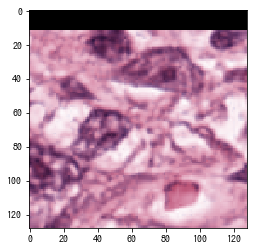

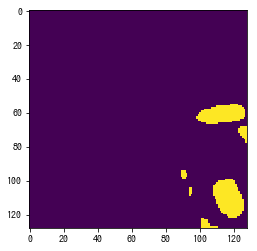

In [10]:
def visualize(index=2):
    img,y=train_generator.__getitem__(index)
    
    fig=plt.figure()
    plt.imshow(img[0])
    fig2=plt.figure()
    print("image id ",train_generator.image_IDs[0])
    print("x shape : {}\ny shape is : {}".format(img.shape,y.shape))
    
    
    plt.imshow((y[0][:,:,0]))
    #fig3=plt.figure()
    #plt.imshow(y[0][:,:,1])
visualize()

In [ ]:
def dice_coef(y_true, y_pred):
    
    y_true_f_1 = K.flatten(y_true[:,:,:,0])
    y_true_f_2 = K.flatten(y_true[:,:,:,1])
    
    y_pred_f_1 = (K.flatten(y_pred[:,:,:,0]))
    y_pred_f_2 = (K.flatten(y_pred[:,:,:,1]))
    
    intersection_1 = K.sum(y_true_f_1 * y_pred_f_1)
    union_1=K.sum(y_true_f_1) + K.sum(y_pred_f_1)
    
    intersection_2 = K.sum(y_true_f_2 * y_pred_f_2)
    union_2=K.sum(y_true_f_2) + K.sum(y_pred_f_2)
    
    dice_1=(2. * intersection_1) / ( union_1+ K.epsilon())
    dice_2=(2. * intersection_2) / ( union_2+ K.epsilon())
    
    return dice_1*0.6+dice_2*0.4

def expend_as(tensor, rep):
        my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
        return my_repeat

def AttnGatingBlock(x, g, inter_shape):
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same')(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    # my_repeat=Lambda(lambda xinput:K.repeat_elements(xinput[0],shape_x[1],axis=1))
    # upsample_psi=my_repeat([upsample_psi])
    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = multiply([upsample_psi, x])

    # print(K.is_keras_tensor(upsample_psi))

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

def UnetGatingSignal(input, is_batchnorm=True):
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 2, (1, 1), strides=(1, 1), padding="same")(input)
    if is_batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attn_unet(pretrained_weights = None,output_channels=1,input_size = (128,128,3),act='relu',optimizer='adam'):
    inputs = Input(input_size)
    assert act in ['relu','leaky_relu']
    assert optimizer in ['adam','sgd']
    if act=='relu':
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        #bach_size x 512 x 512 x 64
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        #bach_size x 512 x 512 x 64
    else:
        conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1=LeakyReLU(alpha=0.5)(conv1)
        #bach_size x 512 x 512 x 64
        conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
        conv1=LeakyReLU(alpha=0.5)(conv1)
        #bach_size x 512 x 512 x 64
    activation='relu'
  
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #bach_size x 256 x 256 x 64
    conv2 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    #bach_size x 256 x 256 x 128
    conv2 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    #bach_size x 256 x 256 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #bach_size x 128 x 128 x 128
    conv3 = Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    #bach_size x 128 x 128 x 256
    conv3 = Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    #bach_size x 128 x 128 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #bach_size x 64 x 64 x 256
    conv4 = Conv2D(512, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    #bach_size x 64 x 64 x 512
    conv4 = Conv2D(512, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    #bach_size x 64 x 64 x 512
    drop4 = Dropout(0.5)(conv4)
    
    #pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #drop5 = Dropout(0.5)(conv5)

    #up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    #merge6 = concatenate([drop4,up6], axis = 3)
    #conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    #conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    
    g1=UnetGatingSignal(drop4)
    #bach_size x 64 x 64 x 1024
    att1=AttnGatingBlock(conv3, g1, 512)
    #bach_size x 128 x 128 x 256
    up7 = Conv2D(256, 2, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))#(conv6))
    #bach_size x 128 x 128 x 256
    merge7 = concatenate([att1,up7], axis = 3)
    #bach_size x 128 x 128 x 512
    conv7 = Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    #bach_size x 128 x 128 x 256
    conv7 = Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    #bach_size x 128 x 128 x 256
    
    g2=UnetGatingSignal(conv7)
    #bach_size x 128 x 128 x 512
    att2=AttnGatingBlock(conv2, g2, 256)
    #bach_size x 256 x 256 x 128

    up8 = Conv2D(128, 2, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    #bach_size x 256 x 256 x 128
    merge8 = concatenate([att2,up8], axis = 3)
    #bach_size x 256 x 256 x 256
    conv8 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    #bach_size x 256 x 256 x 128
    conv8 = Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    #bach_size x 256 x 256 x 128
    
    g3=UnetGatingSignal(conv8)
    #bach_size x 256 x 256 x 256
    att3=AttnGatingBlock(conv1, g3, 128)
    #bach_size x 512 x 512 x 64

    up9 = Conv2D(64, 2, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    #bach_size x 512 x 512 x 64
    merge9 = concatenate([att3,up9], axis = 3)
     #bach_size x 512 x 512 x 128
    conv9 = Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(merge9)
     #bach_size x 512 x 512 x 64
    conv9 = Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv9)
     #bach_size x 512 x 512 x 64
    conv9 = Conv2D(2, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv9)
     #bach_size x 512 x 512 x 2
    conv10 = Conv2D(output_channels, 2, activation = 'sigmoid',padding='same')(conv9)
     #bach_size x 512 x 512 x 1

    model = Model(inputs = inputs, outputs = conv10)
    
    if optimizer=='adam':
        OPT=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000, amsgrad=False)
        print('adam optimizer')
    elif optimizer=='sgd':
        OPT=keras.optimizers.SGD(lr=0.01,momentum=0.8,nesterov=True)
        print('SGD optimizer')
    model.compile(optimizer = OPT, loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef])
    

    return model


class CosineWithRestart(keras.callbacks.Callback):
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=3,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
        
class CheckLR(tf.keras.callbacks.Callback):
   
    def on_epoch_begin(self,epoch,logs):
        print("LR : {}".format(K.eval(self.model.optimizer.lr)))
        
        




In [ ]:
TRAIN_STEPS=train_generator.__len__()
VAL_STEPS=val_generator.__len__()

def create_model_dir():
    model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
    dir_name = os.path.join(os.getcwd(),"unet_model_{}".format(model_start_date))

    if os.path.exists(dir_name):
        print("unet_model already exists in {}".format(dir_name))
        return dir_name
    else:
        os.mkdir(dir_name)
        print(" dir {} made".format(dir_name))
        return(dir_name)
    
dir_name=create_model_dir()
print(dir_name)

In [ ]:
unet_model=attn_unet(input_size=(128,128,3),act='relu',optimizer='sgd')
unet_model.summary()



In [ ]:
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,mode='min',min_delta=0.001,\
                     patience=4,cooldown=0,min_lr= 1e-12,verbose=1)

cosine_annealing_cb=CosineWithRestart(1e-06,0.01,TRAIN_STEPS,lr_decay=1,cycle_length=10,mult_factor=1.5)


model_checkpoint_cb=keras.callbacks.ModelCheckpoint('{}/unet_model_optimum_{}.hdf5'.\
                                      format(dir_name,datetime.datetime.now().strftime("%Y_%m_%d")),\
                                      monitor='val_dice_coef', verbose=1, save_best_only=True, \
                                      save_weights_only=True, mode='max', period=1)


model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
callbacks=[CheckLR(),model_checkpoint_cb,cosine_annealing_cb]

history=unet_model.fit_generator(generator=train_generator,epochs=20,verbose=1,\
                            callbacks=callbacks,\
                                 validation_data=val_generator,use_multiprocessing=True)
fig=plt.figure()
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
fig.savefig('{}/plot_loss_{}.PNG'.format(dir_name,model_start_date))

f1=history.history['dice_coef']
f1_test=history.history['val_dice_coef']

fig2=plt.figure()
plt.plot(f1,label='training')
plt.plot(f1_test,label='testing')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Dice_score')
fig2.savefig('{}/plot_dice_coef_{}.PNG'.format(dir_name,model_start_date))

model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
model_json = unet_model.to_json()
with open("{}/model_{}.json".format(dir_name,model_start_date), "w") as json_file:
    json_file.write(model_json)
unet_model.save_weights("{}/unet_model_final_weights_{}.h5".format(dir_name,model_start_date))
print("Saved model to disk") 



# LOADING TRAINED MODEL

In [ ]:
dir_content=os.listdir()
model_list=[s for s in dir_content if 'unet_model_' in s]
model_list=sorted(model_list)
model_folder=os.path.join(os.getcwd(),model_list[-1])
print("available models are :",model_list,"\n","selected model is :", model_folder)
model_weights=os.path.join(os.getcwd(),model_folder)+"/"+[weights for weights in os.listdir(model_folder) if 'model_final' in weights][-1]
model_architecture=glob.glob(os.path.join(os.getcwd(),model_folder)+"/*.json")[-1]
print(model_weights,model_architecture)


In [ ]:
json_file = open(model_architecture, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_unet = model_from_json(loaded_model_json)
#OPT=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
OPT=keras.optimizers.SGD(lr=0.01,momentum=0.8,nesterov=True)
loaded_model_unet.load_weights(model_weights)
loaded_model_unet.compile(optimizer = OPT, loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef])
print(loaded_model_unet.metrics_names)

In [ ]:
loaded_model_unet.summary()

In [ ]:
def make_pred(img_name,model):
    img=imread(img_name)
    r,c,_=img.shape#1000,1000

    new_r_count=(math.ceil((r-128)/128)+1)#8
    new_c_count=(math.ceil((c-128)/128)+1)#8


    pad_r1=((new_r_count-1)*128-r+128)//2 #12
    pad_r2=((new_r_count-1)*128-r+128)-pad_r1 #12
    pad_c1=((new_c_count-1)*128-c+128)//2 #12
    pad_c2=((new_c_count-1)*128-c+128)-pad_c1#12


    window_shape=(128,128,3)

    arr_img=np.pad(img, [(pad_r1,pad_r2),(pad_c1,pad_c2),(0,0)], 'constant', constant_values=0)#1024 1024 3
    print(arr_img.shape)


    arr_out=skimage.util.view_as_windows(arr_img, window_shape, step=128)
    print(arr_out.shape)
    x,y=arr_out.shape[:2]
    ar2=arr_out.reshape((-1,128,128,3))
    print(ar2.shape)
    y_pred=model.predict(ar2/255)
    #y_pred=y_pred[:,:,:,0]
    #y_pred=np.expand_dims(y_pred,axis=3)
    print(y_pred.shape)
    
    img_temp1=[]
    for i in range(x):
        img_temp1.append(np.concatenate(y_pred[i*y:(i+1)*y],axis=1))
    
    img_temp1=np.array(img_temp1,dtype=np.float_)
    print(img_temp1.shape)
    img_temp1=np.concatenate(img_temp1,axis=0)
    print(img_temp1.shape)
    img_temp1=img_temp1[pad_r1:img_temp1.shape[0]-pad_r2,pad_c1:img_temp1.shape[1]-pad_c2,:]*255
    
    return img_temp1
    #return y_pred
img_path='/datalab/nuclei_seg/norm_ideal'
img_list=os.listdir(img_path)
img_name=img_path+'/'+img_list[1]
y=make_pred(img_name,loaded_model_unet)
plt.imshow(y[:,:,0])
print(y[:,:,0])
cv2.imwrite('asd.jpg',y[:,:,0])

print(y.shape)
print()


In [ ]:
plt.imshow(imread(img_name))
print(imread(img_name).shape)

In [ ]:
print(img_list[1])